# Introduction

One of the many important roles data analytics can play in ecommerce is in deciding how to display search results to customers. Imagine you are searching for a flight from Cape Town to Amsterdam. There are potentially hundreds of different flight options that could be returned. How should the the online travel agent decide what to show you first? The interests of the company and you, the customer, are aligned here - You want to see results that are most relevant to you nearer the top because its convenient, aleviating the need for you to wade through less relevant results. And from the online travel agent's perspective, they want to show you flight option that you are most likely to book nearer to the top, since you will be less likely to leave the site before finding an option that you'd like to book. But how do companies decide what results are most 'relevant' - options that you are most likely to book? One common category of results are ones that are good "value for money". This is intuitive, since people generally want to get the most "bang for buck", nomatter what their price-range. In this notebook, I explore how we can think of value for money by exploring a dataset of wines, which were scraped from the [WineEnthusiast](https://www.winemag.com/) website and which you can find [here](https://www.kaggle.com/zynicide/wine-reviews).


In [263]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

# Change working directory
if 'dir_changed' in locals():
    pass
else:
    os.chdir(os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(sys.argv[1])), os.pardir)))
    dir_changed = False

# Append location of customer modules to path and import modules
sys.path.append('src/custom-modules')
from model_diagnostics import regression_model_report, regression_model_cv_report, plot_actual_vs_predicted
from dataframe_imputer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import metrics

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

wine = pd.read_csv('data/raw/winemag-data-130k-v2.csv', index_col = 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Consider this: you are a data scientist at an online wine store. You are experimenting with a new feature - highlighting the best value for money wine on the top of the search results page. Someone could search for wines from South Africa and get back a bunch of potential results, like this:

In [264]:
wine.loc[(wine['country']=='South Africa'), ['title', 'province', 'designation', 'points', 'price']].head(10)

,title,province,designation,points,price
125,Le Riche 2003 Cabernet Sauvignon Reserve Caber...,Stellenbosch,Cabernet Sauvignon Reserve,91,45.0
129,Camberley 2004 Philosophers' Stone Red (Stelle...,Stellenbosch,Philosophers' Stone,91,25.0
132,Delheim 2001 Grand Reserve Cabernet Sauvignon ...,Simonsberg-Stellenbosch,Grand Reserve,91,30.0
137,Beaumont 2005 Hope Marguerite Chenin Blanc (Wa...,Walker Bay,Hope Marguerite,90,NaN
197,Spier 2014 21 Gables Chenin Blanc (Western Cape),Western Cape,21 Gables,90,23.0
208,Delaire Graff 2013 Reserve White (Coastal Region),Coastal Region,Reserve,90,40.0
210,Eikendal 2014 Chardonnay (Western Cape),Western Cape,NaN,90,20.0
225,Oldenburg 2013 Chardonnay (Stellenbosch),Stellenbosch,NaN,90,25.0
226,Oldenburg 2014 Chenin Blanc (Stellenbosch),Stellenbosch,NaN,90,20.0
256,Goats do Roam Wine Co. 2008 Goat-Roti Syrah-Vi...,Coastal Region,Goat-Roti,89,20.0


You might have some way of sorting by default (maybe by popularity or price) but at the top of the results you would highlight the best value for money wine. The question is, how do you determine which wine that is?

I will be exploring 3 different potential ways of doing this, adding layers of sophistication in each subsequent method:
1. Rank wines from highest to lowest score within their respective price range. The best value for money wine could be the one with the highest rank out of the wines returned by the search.
2. Create a value for money index. The wine with the highest index would be the best value for money.
3. Regress price on available predictors and measure how far above the predicted price each wine is. The best value wine would be the one farthest below its predicted price.

This notebook proceeds in 3 parts - first, I am going to do some data wrangling in order to get the data into a form that will be easier to analyse later. Then I will explain and develop the 3 methods for working out which wines are the best value for money. Finally, I will wrap up with some potential issues and next steps for putting such a feature into production, before concluding with a summary.

# Wrangling

In [265]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Extracting date from the title

It would be interesting to look at the year in which each wine was produced. While this isn't included as a column in the dataset, we can extract is from the `title` using regex. We can do this by searching throught the titles for numbers that match years in the 20th and 21st centuries. I won't worry about older wines.

In [266]:
# regex to extract date (matching wines from 20th and 21st centuries)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_matched = pd.notnull(wine['year'])  # Find where there is a match (no match signified by `NaN`)
wine.loc[year_matched, 'year'] = wine.loc[year_matched, 'year'].apply(lambda x: x.group(0))  # Extract year where there is a match
wine = wine[~wine['year'].isnull()]  # Drop columns where `year` is null (no match)
wine['year'] = wine['year'].astype(int, errors='ignore')

### Duplicates

The dataset contains some duplicates. We can go ahead and drop duplicated rows where every column is duplicated. I'll keep the first occurance.

In [267]:
print('Duplicated rows:')
wine.duplicated().value_counts()
wine = wine.drop_duplicates(keep='first')

Duplicated rows:


False    115703
True       9642
dtype: int64

We can see that even though we've dropped rows where *every* column is diplicated, there are cases where the `title` is duplicated but there may be different scores. Which one do we keep? It appears that the duplicates arise where a wine is reviewed more than once. For example, `Ascension Cellars 2015 Silver White (Paso Robles)` appears twice, but the reviews were published in [2016](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles/) and [2017](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles-253492/), respectively. You can't see that from the data, since publication date isn't included. But I discovered this by going to the [WineEnthusiast](https://www.winemag.com/) website, from which this data were scraped, and searching for the offending reviews.

Since publication date isn't included in the data, we can't distinguish between reviews and there's no systematic way to decide which to keep. I'll keep the first occurance as it appears in the dataset. This solves the duplicating problem but it's worth noting that bias could be introduced here, as we're only keeping one review and there may be some information about wines with multiple reviews that we're missing. However, dropping both reviews where the `title` is duplicated could also introduce bias, since we'd only be looking at the subset of wines that have only one review. A better solution would be to include publication date and either include both reviews or systematically include one (the first or last publication for instance).

In [268]:
wine[wine.duplicated(subset='title', keep=False)].sort_values('title').head()
wine = wine.drop_duplicates(subset='title', keep='first')
print('Duplicated rows:')
wine.duplicated('title').value_counts()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
64164,Italy,"Fig, stewed prune, sun baked soil, camphor and...",Rombone Elisa,92,47.0,Piedmont,Barbaresco,NaN,Kerin O’Keefe,@kerinokeefe,Ada Nada 2012 Rombone Elisa (Barbaresco),Nebbiolo,Ada Nada,2012
23714,Italy,This initially opens with funky aromas of barn...,Rombone Elisa,88,NaN,Piedmont,Barbaresco,NaN,Kerin O’Keefe,@kerinokeefe,Ada Nada 2012 Rombone Elisa (Barbaresco),Nebbiolo,Ada Nada,2012
96548,Portugal,"Soft and rich wine, its perfumes and sweet tan...",Senses,87,NaN,Alentejano,NaN,NaN,Roger Voss,@vossroger,Adega Cooperativa de Borba 2009 Senses Syrah (...,Syrah,Adega Cooperativa de Borba,2009
39541,Portugal,"For a Syrah, this is soft, offering more of th...",Senses,87,13.0,Alentejano,NaN,NaN,Roger Voss,@vossroger,Adega Cooperativa de Borba 2009 Senses Syrah (...,Syrah,Adega Cooperativa de Borba,2009
25762,Portugal,This big and bold wine exudes power and fruiti...,Bridão Reserva,91,14.0,Tejo,NaN,NaN,Roger Voss,@vossroger,Adega Cooperativa do Cartaxo 2011 Bridão Reser...,Portuguese Red,Adega Cooperativa do Cartaxo,2011


Duplicated rows:


False    115229
dtype: int64

### Log-normalise price

Wine doesn't look like a nicely-behaved normal distribution. It has an extremely long tail to the right.

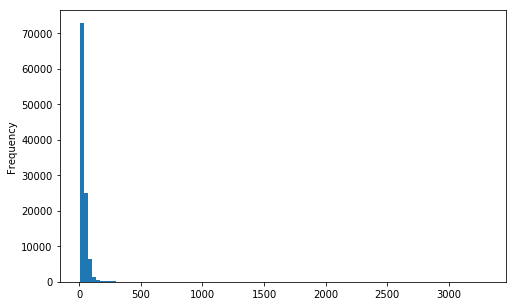

In [269]:
wine['price'].plot.hist(bins=100, figsize=(8, 5));

If we take the natural logarithm of price, we can now see a much more nicely-behaved price distribution. However, there are still some large outliers. I'll save the log of price in the column `log_price`.

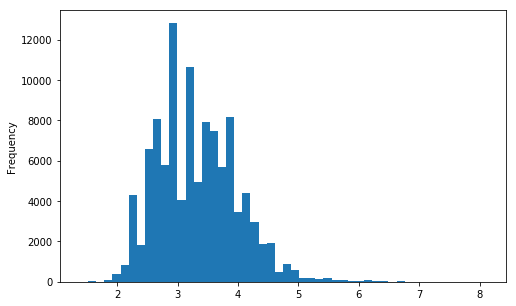

In [270]:
wine['log_price'] = np.log(wine['price'])
wine['log_price'].plot.hist(bins=50, figsize = (8, 5));

### Deal with outliers

We can see that `price` has a very long tail. While there are more scientific ways to handle outliers, it we just cut out any wines that are greater than 6 log-dollars, we get a much ore balanced picture. 

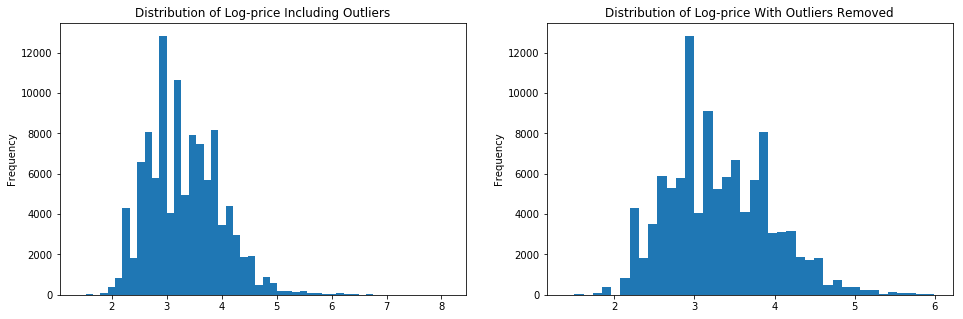

In [271]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
wine['log_price'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Distribution of Log-price Including Outliers')
wine.loc[wine['log_price']<=6, 'log_price'].plot.hist(bins=40, ax=ax2)
ax2.set_title('Distribution of Log-price With Outliers Removed')
plt.show();

To keep things simple, I'm going to go ahead and remove wines with `log_price` above 6. We can see that the mean and median are very close (3.31 vs 3.22) and a balanced boxplot. There are still quite a few values larger than the 75th percentile but I can live with that.

count    107209.000000
mean          3.316413
std           0.647367
min           1.386294
25%           2.833213
50%           3.218876
75%           3.737670
max           5.991465
Name: log_price, dtype: float64

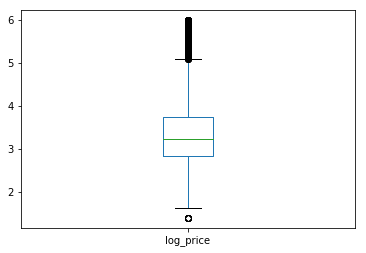

In [272]:
wine = wine.loc[wine['log_price']<=6]
wine['log_price'].describe();
wine['log_price'].plot.box()

# Value for money wines

Value for money is difficult to quantify. Ideally, we would want some explicit indicator to guide us - for instance, a professional wine-expert who could tell us which wines she viewed as good value for money. In our dataset, we don't have such an indicator, which makes validating the proposed methods quantitatively difficult. However, this doesn't mean it's impossible to come up with a workable method as a first-pass, that could be improved upon in subsequent iterations when more data is available.  

Value is an iffy concept and can be very subjective but essentially it involves some sort of comparison of between "value" and "price". While we also don't have an explicit measure of "value", we do have the field `points`, which has been assigned by reviewers. These scores are also going to be somewhat subjective but, since they have been awarded by professional reviewers, it makes sense that they would reflect value to some extent. We shouldn't expect this to be a perfect measure of value but it makes sense that it would be a good proxy. This also makes empirical sense. The boxplot below shows that wines that score higher tend to be more expensive. We can see that there is a lot of overlap but the median score increases consistently with the log-price category. This is what we would expect, since better wines will generally cost more. I will further discuss the efficacy of using the score as a measure of value further under the section "Potential problems and next steps" but for now let's assume that using it makes sense and look at some ways we might be able to use it to surface good value for money wines. 

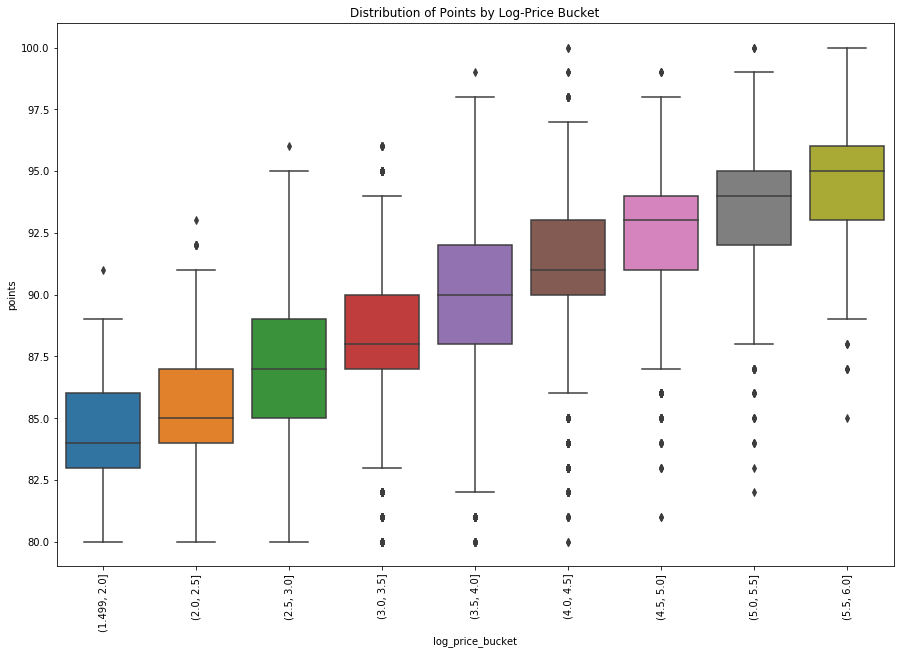

In [273]:
wine['log_price_bucket'] = pd.cut(wine['log_price'], np.arange(1.5, 6.5, 0.5), include_lowest=True)
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['points'], x=wine['log_price_bucket'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Points by Log-Price Bucket')
plt.show();

## Relative score within price category

A very simple way of thinking about value for money is that better value for money wines are the ones that have the highest score for the price bucket that they are in. We could group the wines into price buckets (as in the boxplots above) and rank them within their respective buckets from highest score to lowest. The highest-ranking wines (with rank 1) within their price buckets would be the best value for money. This gives us a way to compare wines even when they might lie in different buckets - a wine that ranks 3 in one price bucket could be deemed to be better value for money than one that ranks 5 in a different bucket. The reason I use price buckets instead of just ranking wines of the same price is that some at some prices there are not a lot of wines so the ranking wouldn't work.

Let's go ahead and implement this method and see how it sorts our search result from above. As I've mentioned above, there isn't a rigorous way to validate whether we are surfacing good value for money wines but we can at least see whether the results are intuitive. I'll compare the 3 wines which our model has identified as the best value for money with 3 wines in the middle of the value for money distribution.

In [276]:
# Rank the wines by `points` within `log_price_bucket`s
wine['rank_group_score'] = wine.groupby('log_price_bucket')['points'].rank(ascending=0)

searched = wine.loc[(wine['country']=='South Africa'), 
         ['title', 'year', 'province', 'region_1', 'variety', 'designation', 'winery', 
          'points', 'price', 'log_price_bucket', 'rank_group_score']]
print('Best value for money wines:')
searched.sort_values('rank_group_score', ascending=True).head(3)
mid = [np.round(searched.shape[0]/2)]
mid = [mid[0]-1] + mid + [mid[0]+1]
print('Mid value for money wines:')
searched.sort_values('rank_group_score', ascending=True).iloc[mid]

Best value for money wines:


,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score
12255,Simonsig 1998 Cabernet Sauvignon (Stellenbosch),1998,Stellenbosch,NaN,Cabernet Sauvignon,NaN,Simonsig,93,15.0,"(2.5, 3.0]",91.5
9912,De Toren 2014 Book 17 XVII Red (Stellenbosch),2014,Stellenbosch,NaN,Bordeaux-style Red Blend,Book 17 XVII,De Toren,95,330.0,"(5.5, 6.0]",120.5
49578,KWV 2001 Cathedral Cellar Chardonnay (Western ...,2001,Western Cape,NaN,Chardonnay,Cathedral Cellar,KWV,90,12.0,"(2.0, 2.5]",142.0


Mid value for money wines:


,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score
699,Kanonkop 2012 Estate Wine Pinotage (Simonsberg...,2012,Simonsberg-Stellenbosch,NaN,Pinotage,Estate Wine,Kanonkop,91,40.0,"(3.5, 4.0]",8179.0
51068,Simonsig 2012 Merindol Syrah (Stellenbosch),2012,Stellenbosch,NaN,Syrah,Merindol,Simonsig,91,44.0,"(3.5, 4.0]",8179.0
694,Reyneke 2013 Reserve Sauvignon Blanc (Stellenb...,2013,Stellenbosch,NaN,Sauvignon Blanc,Reserve,Reyneke,91,50.0,"(3.5, 4.0]",8179.0


That's not too bad. We can see that the best value for money wine scored 93 but costs only \$15. The 2nd best value for money wine has a score of 95 but this is very expensive at \$330. It's not clear whether this really represents good value for money and surfacing such a result at the top might alienate most customers. In the comparison group we see wines that have scores that are one point higher than the last wine in the top pile (90) but going for prices of more than 3 times higher. This simple method seems to do a good job at surfacing some good value for money wines.

The above method will work for figuring out if a wine is comparitively good value for its price category. However, there are 3 things that could perhaps be improved:
1. It is somewhat clunky in that we have to first separate wines by category before ranking them. You have to know which category each wine is in before you can make a comparison.
2. We are using somewhat arbitrary log-price buckets to group the wine.
3. It doesn't provide a way to quantitatively compare value for money across categories. 

Let's see if we can improve on this.

## Ratio of standardised score to log price

How does a wine that ranks 100 in bucket (3.5, 4.0] compare to one that ranks 50 in bucket (3, 3.5]? The second wine has a better rank within its price bucketbut is it really a better value for money wine? It would be nice to have one number that we could use to compare them systematically. Now we can't just divide `points` by `price` because the scales of each variable don't make sense. We can see this below, where I have plotted `points_per_dollar` within price cateogry buckets. This naive index says that value for money decreases as the price of the wine increases. This isn't the type of behaviour that we'd want from an index that measures value for money - within each price category there should be wines with varying degrees of value for money. We might expect to see the distribution of value for money differing somewhat between price categories but shouldn't expect the average value for money to decrease systematically.

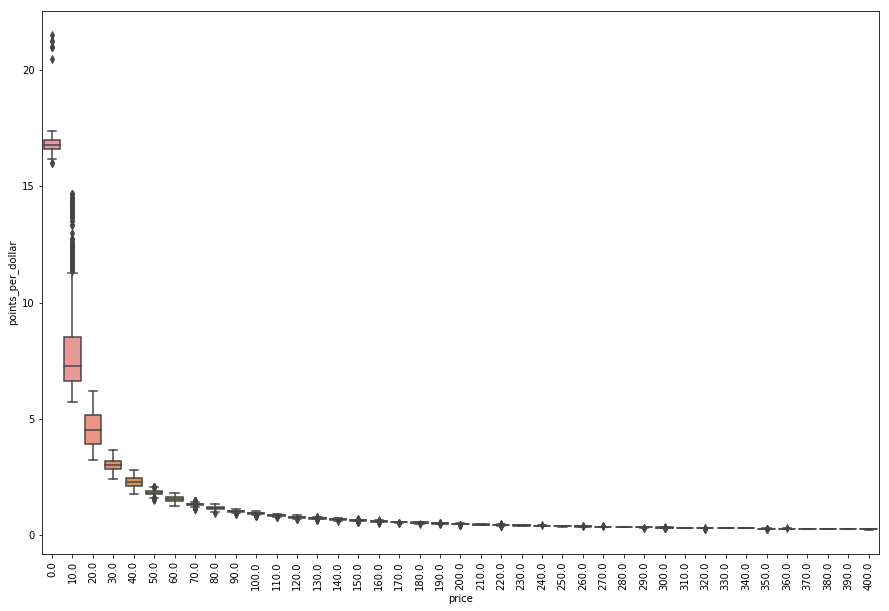

In [105]:
wine['points_per_dollar'] = wine['points']/wine['price'] 

wine['price_cat'] = pd.cut(wine['price'], range(0, wine['price'].max().astype(int), 5), include_lowest=True)
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['points_per_dollar'], x=round(wine['price'], -1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

The reason we see this is behvaviour is twofold - and both necessitate our modifying the numerator and denominator for our index. For one, the points aren't on a continuous scale. They range between 80 and 100. To illustrate why this is a problem, imagine if you have a \$20 wine and you want to compare its value for money to a bottle that has a score of 85 and price of $10, giving it a score:price ratio of 8.5. Since your bottle is double the price, for it to have a score:price ratio of 8.5, it would need to have double the points. But that would mean that it would need a score of 170, which is impossible. So the points need to be scaled so that they show relative differences. Second, as we have already seen above, the distribution of price is skewed with very large prices. It is approximately log-normally distributed - large prices are very large. 

This motivates for scaling points so that differences between scores are relative (we can do this by finding the difference between the score and the minimum score and dividing this by the range - the difference between the minimum and maximum scores) and using log-price in the denominator.

The graph below shows how `scaled_points_per_log_dollar` (the `scaled points` divided by `log_price`) is distributed over buckets of 0.5 log-dollars. The medians in each price bucket are much more stable between 0.11 and 0.14. An interesting outcome of this index is that wines that are more expensive tend to have a tighter distribution around the median. This could be interpreted as meaning that more expensive wines are more consistently closer to average value for money. While cheaper wines have the potential to be worse value for money, they can also be better value than more expensive wines. This makes intuitive sense. More expensive wines are less likely to be of bad quality. However, you will also be hard-pressed to find bargains.

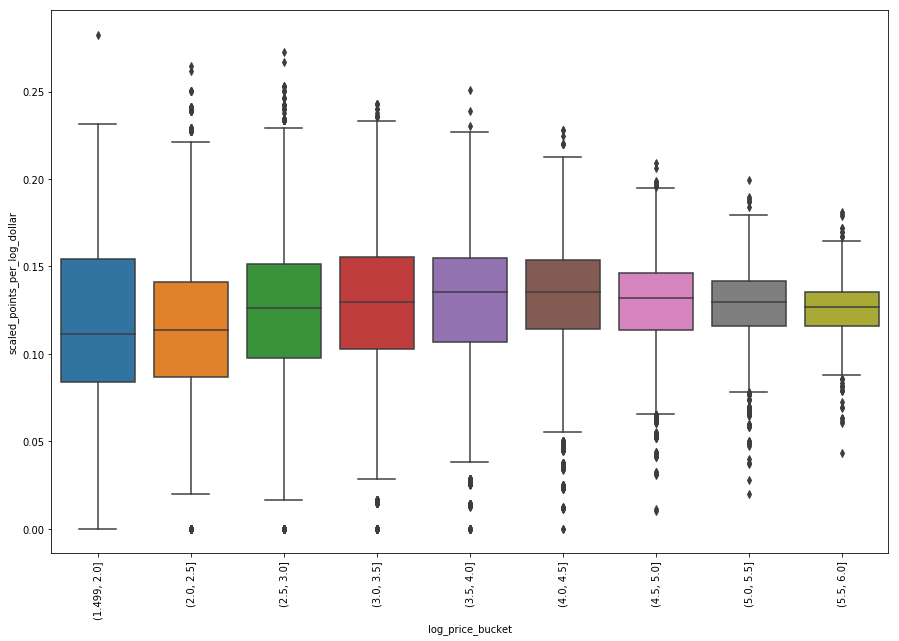

                    median       max       min
log_price_bucket                              
(1.499, 2.0]      0.111622  0.282644  0.000000
(2.0, 2.5]        0.113780  0.264494  0.000000
(2.5, 3.0]        0.126236  0.272910  0.000000
(3.0, 3.5]        0.129406  0.242730  0.000000
(3.5, 4.0]        0.135543  0.251045  0.000000
(4.0, 4.5]        0.135453  0.228205  0.000000
(4.5, 5.0]        0.131756  0.209099  0.010272
(5.0, 5.5]        0.129724  0.199575  0.019958
(5.5, 6.0]        0.126660  0.181111  0.043340


In [283]:
def scale(series):
    return (series - series.min()) / (series.max() - series.min())
wine['scaled_points'] = scale(wine['points'])

wine['scaled_points_per_log_dollar'] = wine['scaled_points']/wine['log_price'] 

fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['scaled_points_per_log_dollar'], x=wine['log_price_bucket'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print(wine.groupby('log_price_bucket')['scaled_points_per_log_dollar'].agg(['median', 'max', 'min']));

What's nice about this index is that the value itself gives us a sense of how good a value for money the wine is, nomatter which price category the wine is in. We can also see that our new index is quite nicely distributed around the mean, while `rank_group_score`, the previous ranking metric from above does not have this characteristic. 

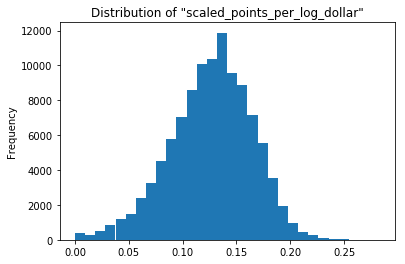

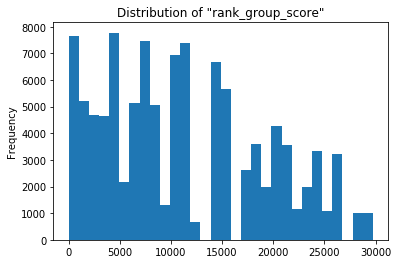

In [285]:
wine['scaled_points_per_log_dollar'].plot.hist(bins=30, title='Distribution of "scaled_points_per_log_dollar"')
plt.show();
wine['rank_group_score'].plot.hist(bins=30, title='Distribution of "rank_group_score"')
plt.show();

This method also does a good job at surfacing highly-scoring wines that aren't too expensive. Implementing this method, and performing the same search as before:

In [286]:
searched = wine.loc[#(wine['variety']=='Cabernet Sauvignon') 
         (wine['country']=='South Africa'), 
         ['title', 'year', 'province', 'region_1', 'variety', 'designation', 'winery', 
          'points', 'price', 'log_price_bucket', 'rank_group_score', 'scaled_points_per_log_dollar']]

searched.sort_values('scaled_points_per_log_dollar', ascending=False).head(3)
mid = [np.round(searched.shape[0]/2)]
mid = [mid[0]-1] + mid + [mid[0]+1]
searched.sort_values('scaled_points_per_log_dollar', ascending=False).iloc[mid]

,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar
12255,Simonsig 1998 Cabernet Sauvignon (Stellenbosch),1998,Stellenbosch,NaN,Cabernet Sauvignon,NaN,Simonsig,93,15.0,"(2.5, 3.0]",91.5,0.240025
12256,Jardin 1998 Chardonnay (Stellenbosch),1998,Stellenbosch,NaN,Chardonnay,NaN,Jardin,92,17.0,"(2.5, 3.0]",376.5,0.211774
49578,KWV 2001 Cathedral Cellar Chardonnay (Western ...,2001,Western Cape,NaN,Chardonnay,Cathedral Cellar,KWV,90,12.0,"(2.0, 2.5]",142.0,0.201215


,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar
77490,Bosman Family Vineyards 2008 Pinotage (Welling...,2008,Wellington,NaN,Pinotage,NaN,Bosman Family Vineyards,90,45.0,"(3.5, 4.0]",11706.0,0.131349
51327,Thelema 2007 The Mint Cabernet Sauvignon (Stel...,2007,Stellenbosch,NaN,Cabernet Sauvignon,The Mint,Thelema,90,45.0,"(3.5, 4.0]",11706.0,0.131349
113682,Veenwouden 2002 Merlot (Paarl),2002,Paarl,NaN,Merlot,NaN,Veenwouden,90,45.0,"(3.5, 4.0]",11706.0,0.131349


This method surfaces two of the same wines as `rank_group_score` as best value for money. It arguably does a better job for our purposes than than the prviou method because it returned "Jardin 1998 Chardonnay", which has a score of 92 and costs only \$17, instead of the "De Toren 2014" which scores 95 and costs \$330. While an expert may actually agree that the De Toren is better value for money, most customers will probably not agree. In the comparison group, we see that this method deems wines with scores of 90 and prices of \$45 as mediocre value for money. These wines rank the same as wine number 3 on the best value for money list but cost almost 4 times more.

While this metric seems to work for our purposes, it is also quite naive because it only looks at the trade-off between score and price. In reality, value for money is more nuanced. The final approach, which I put forward in the following section, attempts a remedy.

## Regression model to predict price and then flag wines that have prices lower than expected

The above method for determining value for money, by working out an index that compares score to price, shows some improvements over the simpler method of ranking wines within price buckets and comparing these ranks. However, both methods fail to capture certain nuances. What if score isn't the sole factor that people care about when purchasing a wine? What if there are other things that determine what price someone is willing to pay for a wine or what constitutes 'value'? For example, wines from a particular year and place, or of a particular variety, might tend to be priced differently. If this is the case then simply looking at the score might cause us to think that a wine is overpriced when in fact it is not. 

On a more theoretical level, value is just what someone is willing to pay for something. Microeconomics tells us that the price of a good on the open market reflects its "value" to society. While this might not be the agreed-upon value for everyone, it is a good definition for these purposes. If we take price as reflecting value generally then a wine that is priced lower than it "should" be is good value for money. Following this logic, one method that we could use to surface value for money wine is to estimate the price of the wine, based on the attributes that we have for it, and compare that to the actual price. If the actual price is lower than what we predict then we can say that it is good value for money. By comparing how far our prediction is from the actual value (working out the `residual`), we can attempt to quantify how good value for money a wine is.

First, Let's split the data into train and test sets so that we have data put aside for validation later.

In [111]:
train, test = np.split(wine.sample(frac=1), [int(0.5*len(wine))])

In order to get a baseline, let's just regress price on score.

Average Root Mean Squared Error: 0.5127, which is 11.13% of the range of y
Average R2: 0.376
Average adjusted R2: 0.3758


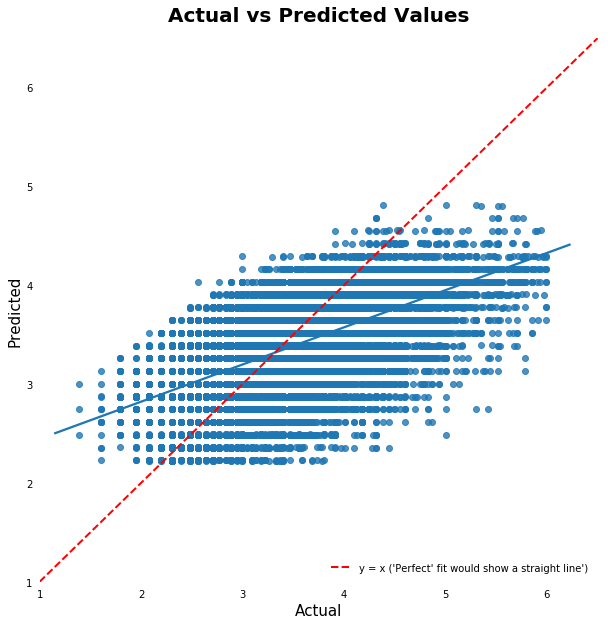

In [112]:
feature_cols = ['scaled_points']  # Only using points

y_train = train['log_price']  
X_train = train[feature_cols]

linreg = LinearRegression()
regression_model_cv_report(X_train, y_train, linreg, n_folds=10)  # This is my own function that runs some model diagnostics using k-fold cross-validation

y_pred = cross_val_predict(linreg, X_train, y_train, cv=10)
plot_actual_vs_predicted(y_train, y_pred, xlim=(1, 6.5), ylim=(1, 6.5), legend_loc='lower right')

From the above output, we can see that the cross-validated RMSE of our model is relatively high at about 0.5, representing about 11% of the range of the wine's log-price. The adjusted R2 of 0.38 means that the score explains 38% of the variance in price. The graph below compares actual and predicted values. The best-fit line between these points is the solid blue line. A model that predicted price perfectly would have predictions that lie on the red line y=x. As we can see, our model tends to over-predict lower-priced wines and under-predict higher-priced wines.

This isn't bad, condsidering we only have one feature. Let's try do better using the data that we have.

Below, I have plotted other columns against price. We can see that country, province, region, year, and variety could be used to differentiate price-levels of wines. This doesn't say anything about a _causal_ relationship but it suggests that we could possible add some other features in the model to better predict price. Different wineries also show different median prices but I didn't visualise that here because there are so many of them.

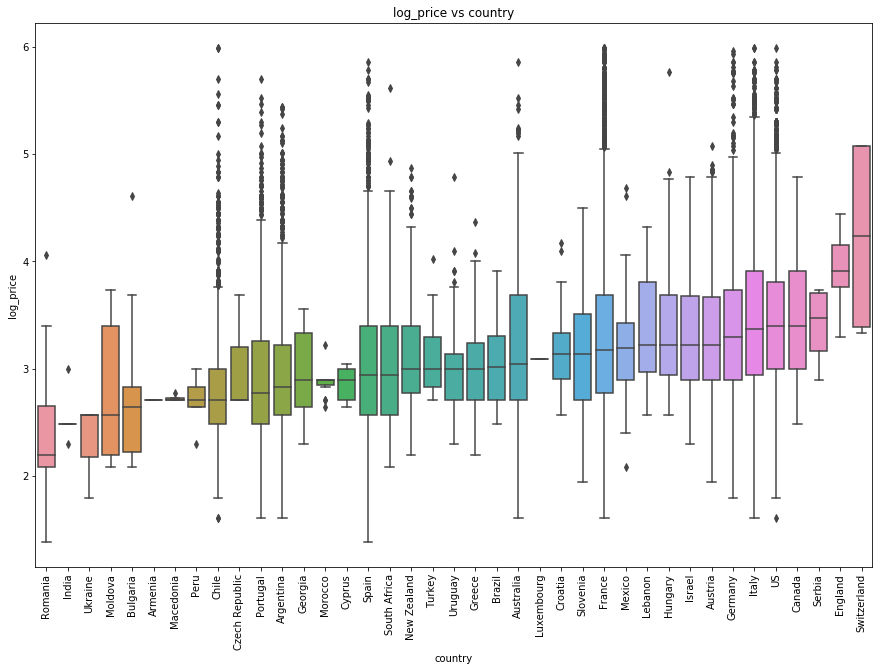

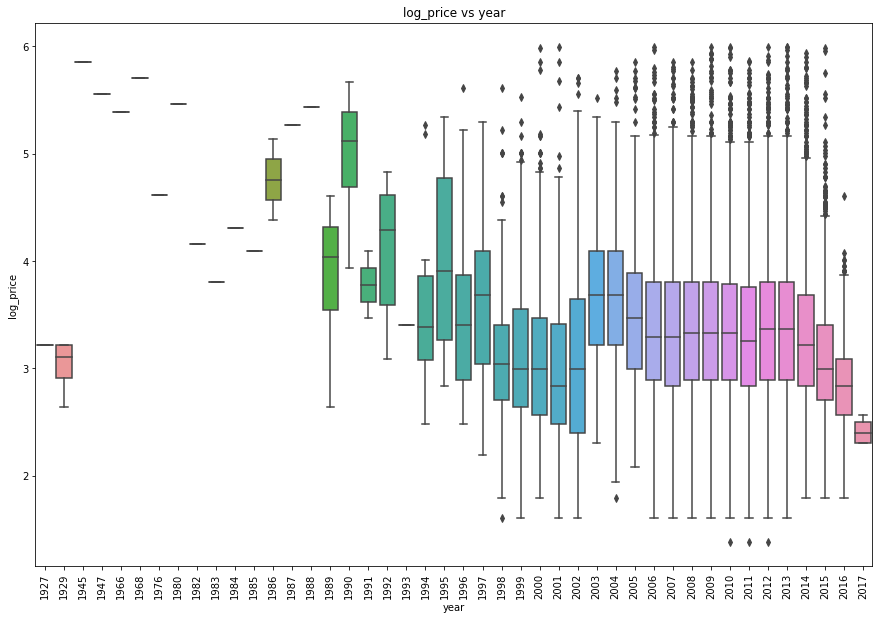

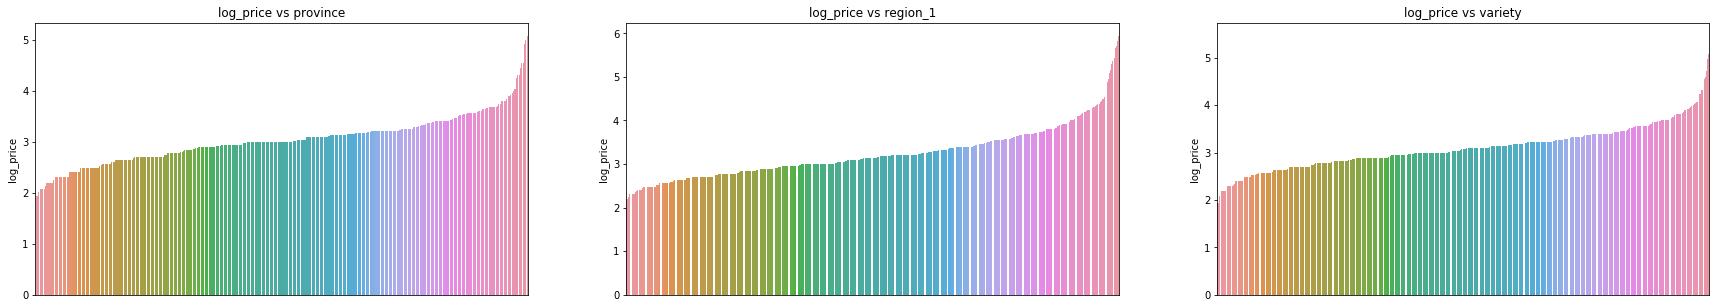

In [287]:
col = 'country'
fig, ax = plt.subplots(figsize = (15, 10))
medians = train.groupby(col)['log_price'].median().sort_values(ascending=True)
sns.boxplot(y=train['log_price'], x=train[col], order=medians.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('log_price vs {0}'.format(col))
plt.show();

wine_w_year = train.loc[train['year'].notnull(), ['year', 'log_price']]
col = 'year'
fig, ax = plt.subplots(figsize = (15, 10))
rank = sorted(list(wine_w_year['year'].unique()))
sns.boxplot(y=wine_w_year['log_price'], x=wine_w_year[col], order=rank)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('log_price vs {0}'.format(col))
plt.show();

cols_to_plot = ['province', 'region_1', 'variety']
fig, axes = plt.subplots(1, 3, figsize = (30, 5))
for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    medians = train.groupby(col)['log_price'].median().sort_values(ascending=True)
    sns.barplot(y=medians, x=medians.index, ax=ax)
    ax.set_title('log_price vs {0}'.format(col))
    ax.get_xaxis().set_visible(False)
plt.show();

We can't just throw all of these new features into the model because they are not continuous. `Year` could be seen as continuos but we can see in the plot above between `year` and `log_price` that there isn't any obvious continuous relationship if we treat it as such. One can deal with such features by constructing dummy variables. However, there are too many categories here compared to observations to do this. There are several different methods that one can employ to get around this. One way would be to use a clutering algorithm to group the data into a smaller number of relevant combinations of features. I have chosen to simply recode them in quintiles. First, we find the median price for each category. Then we can assign the category to quintiles based on where that median sits on the distribution compared to the medians for all the other categories. Then we can create dummy variables based on these quintiles. I have done that below.

In [288]:
cols_to_recode = ['country', 'year', 'province', 'region_1', 'variety', 'designation', 'winery']
def recode_cols(cols_to_recode, df):
    medians = {}
    for col in cols_to_recode:
        col_medians = df.groupby(col)['log_price'].median().sort_values(ascending=True).reset_index()  # Get median price, by group
        col_medians['quintiles'] = pd.qcut(x=col_medians['log_price'], q=5, labels=[1, 2, 3, 4, 5])  # Get quintile for each median value
        col_medians.index = col_medians[col]
        col_medians = col_medians.drop(col, axis=1)
        df[col + '_quintile'] = df[col].map(col_medians['quintiles'])  # Create new column in `df` which contains the quintile that that observation falls into
        medians[col] = col_medians
    return df, medians

train, medians = recode_cols(cols_to_recode, train)

We are now ready to run our regression

Average Root Mean Squared Error: 0.2978, which is 6.47% of the range of y
Average R2: 0.7895
Average adjusted R2: 0.788


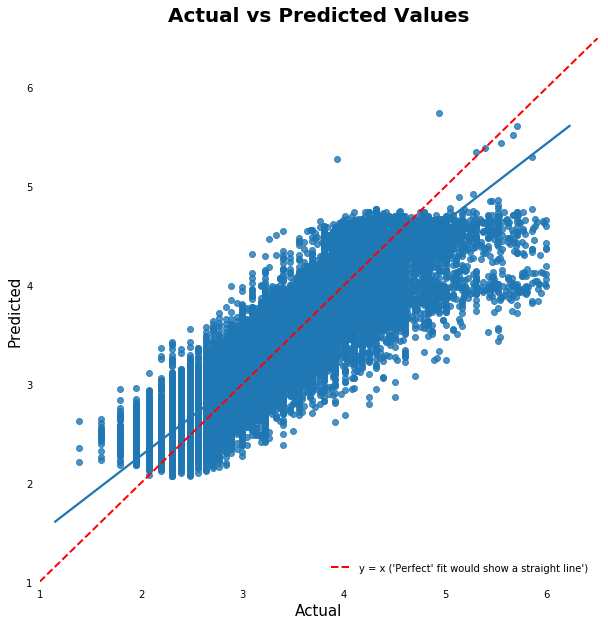

In [222]:
feature_cols = ['scaled_points', 'country_quintile', 'year_quintile', 'province_quintile', 'region_1_quintile', 'variety_quintile', 'designation_quintile', 'winery_quintile']

y_train = train['log_price']
X_train = train[feature_cols]
X_train = pd.get_dummies(X_train).reset_index()  # Create dummies

linreg = LinearRegression()
regression_model_cv_report(X_train, y_train, linreg, 10)

y_pred = cross_val_predict(linreg, X_train, y_train, cv=10)
plot_actual_vs_predicted(y_train, y_pred, xlim=(1, 6.5), ylim=(1, 6.5), legend_loc='lower right')

We can see that this does produce a large improvement, with an RMSE that is about 6.5% of the range of log-price (as oppsed to 11%) and an adjusted R2 of 40 percentage points higher (from 0.58 from 0.38). While the model still under-predicts lower-priced wines and over-predicts higher-priced wines, the predicted values are closer to the actual values and the slope of best-fit line through those points is closer to the 'perfect-fit' y=x line than before. This looks really good but, as I expand upon below, is probably overfitting the data.

We could keep going and try different types of models and different specifications but, for now, let's go with this model and see how it performs by using it to predict values in the test-set. Off the bat, we can expect this model to generally over-fit the sample - not because of the regression model specification as such but because of the way we recode the variables. In order to get a sense of how our model would perform out of sample, we need to recode the variables in the test-set using only data from the test-set. This is because we want to know how well we can predict price given data that __we have not seen before__. However, the recoding above happened _before_ cross-validation. This is bound to lead to overfitting because we are using validation observations to inform the recoding. This is called "leakage". We could have avoided this by doing the recoding within each validation fold. By validating the model on the test-set, we are getting a truer picture of how our model would perform out of sample. A particular problem that will probably arise here is where a category exists in the training set but not the test set. For example, if a wine from a winery that we haven't seen comes along, we assign it the median value and lose what is a very good predictor of price. Because there are many categories and so many different wineries, this will happen quite often.

Below, we can see the ramifications of that overfitting. The final R2 is 0.61 and RMSE is 0.41. These values are, as predicted, quite a lot worse than the train-set cross-validation results.

Average Root Mean Squared Error: 0.4037, which is 8.77% of the range of y
Average R2: 0.609
Average adjusted R2: 0.6087


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

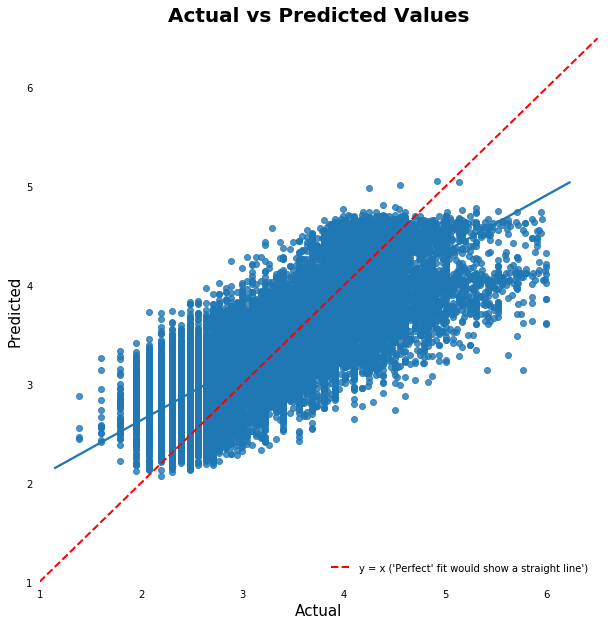

In [289]:
imp_test = DataFrameImputer().fit_transform(test[['country', 'year', 'province', 'region_1', 'variety', 'designation', 'winery']])
imp_test['scaled_points'] = test['scaled_points']
imp_test['log_price'] = test['log_price']

for col in cols_to_recode:
    imp_test[col + '_quintile'] = imp_test[col].map(medians[col]['quintiles']).fillna(3)
    
y_test = imp_test['log_price']
X_test = imp_test[feature_cols]
X_test = X_test.fillna(X.median())
X_test = pd.get_dummies(X_test).reset_index()

results = regression_model_report(X_train, y_train, X_test, y_test, linreg) 

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
plot_actual_vs_predicted(y_test, y_pred, xlim=(1, 6.5), ylim=(1, 6.5), legend_loc='lower right')

This model isn't great but it's not too bad for a first iteration so I'll keep going with it. To get our final results, we can learn the model on the full set of data.

In [290]:
wine_imp = DataFrameImputer().fit_transform(wine[['country', 'year', 'province', 'region_1', 'variety', 'designation', 'winery']])
wine_imp['scaled_points'] = wine['scaled_points']
wine_imp['log_price'] = wine['log_price']

cols_to_recode = ['country', 'year', 'province', 'region_1', 'variety', 'designation', 'winery']
wine_imp, medians = recode_cols(cols_to_recode, wine_imp)

y = wine_imp['log_price']
X = wine_imp[feature_cols]
X = X.fillna(X.median())
X = pd.get_dummies(X).reset_index(drop=True)

linreg.fit(X, y)
y_pred = linreg.predict(X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

I ran the same search as before, which you can see below. This model does show some potential but it's not clear that it performs better than the previous method. As I've mentioned numerous times, it's difficult to quantitatively validate such a model because we don't have an objective indicator for which wines really are good value for money. But, as before, let's give it a try, using common-sense.

The wine with the best value for money has a score of 92 and price of \$35. This is more expensive than some other wines that scored similarly. However, we now care about things other than price. That was the point of building the more sophisticated model in the first place. Vilafonté is an expensive winery, with a mean price of \$75 so actually this could be seen as a good deal in this respect. The Morgenhof in the the top category has the same points and price as a wine in the top of the category in the previous section. However, Mogenhof is generally a more expensive wine so it seems fitting that it would have desplaced the other. That the Makulu wine should be deemed good value for money is less obvious. It is very cheap but it also has a very low score. This could be justified if there were other relevant differences that could determine prices. But this doens't seem to be the case here and might just reflect bias in our model of over-estimating the price of cheaper wines.

One of the main reasons why we might expect a less than stellar result using this model is that it systematically over-predicts expensive wines and under-predicts cheaper wines. This plays out in more expensive wines appearing to be worse value and less expensive wines appearing better value. Also, the model probably isn't predictive enough, expecially at the extreme prices, to really tell what price wines should be. I discuss this in a little more detail below. 

In [291]:
wine['predicted_price'] = np.exp(y_pred)
wine['residual_pct'] = np.exp(y)/np.exp(y_pred)

searched = wine.loc[(wine['country']=='South Africa'), 
         ['title', 'year', 'province', 'region_1', 'variety', 'designation', 'winery', 
          'points', 'price', 'log_price_bucket', 'rank_group_score', 'scaled_points_per_log_dollar',
         'predicted_price', 'residual_pct']]

searched.sort_values('residual_pct', ascending=True).head(3)
mid = [np.round(searched.shape[0]/2)]
mid = [mid[0]-1] + mid + [mid[0]+1]
searched.sort_values('residual_pct', ascending=True).iloc[mid]

,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar,predicted_price,residual_pct
126525,Vilafonté 2007 Series M Red (Paarl),2007,Paarl,NaN,Bordeaux-style Red Blend,Series M,Vilafonté,92,35.0,"(3.5, 4.0]",4907.5,0.168760,84.351919,0.414928
104151,Makulu 2008 Shiraz (Western Cape),2008,Western Cape,NaN,Shiraz,NaN,Makulu,83,6.0,"(1.499, 2.0]",392.0,0.083717,13.968151,0.429549
75848,Morgenhof 1999 Estate Chardonnay (Stellenbosch),1999,Stellenbosch,NaN,Chardonnay,Estate,Morgenhof,90,12.0,"(2.0, 2.5]",142.0,0.201215,26.610637,0.450947


,title,year,province,region_1,variety,designation,winery,points,price,log_price_bucket,rank_group_score,scaled_points_per_log_dollar,predicted_price,residual_pct
94549,Vins d'Orrance 2013 Cuvée Anais Chardonnay (We...,2013,Western Cape,NaN,Chardonnay,Cuvée Anais,Vins d'Orrance,91,32.0,"(3.0, 3.5]",4055.0,0.158696,35.634106,0.898016
62843,De Wetshof 2002 Rhine Riesling Riesling (Rober...,2002,Robertson,NaN,Riesling,Rhine Riesling,De Wetshof,85,12.0,"(2.0, 2.5]",6047.5,0.100607,13.362714,0.898021
67996,Goats do Roam Wine Co. 2006 The Goatfather Red...,2006,Western Cape,NaN,Red Blend,The Goatfather,Goats do Roam Wine Co.,89,13.0,"(2.5, 3.0]",5972.5,0.175442,14.469719,0.898428


# Potential problems & next steps

## Potential issues

I have flagged potential issues and improvements for the three methods above. However, there are some more general issues that I'll mention here.

The original rationale of trying to surface good value for money wines is that it could be useful to flag these at the top of search results. If this leads to additional sales, this would be a win-win for both customers and online wine store - customers would get "value" in that they find good wines for the price and the business would see sales increase. However, yhere could be a potential unintented negative consequence of this sort of feature on total sales value. Total sales equals numer of wines sold multiplied by the revenue per wine sold. Even if the store did sell more wine, if the good value for money wines tend to be lower priced than the wines that customers might otherwise buy, then the _total_ sales amount could be lower than before. This isn't necessarily good for business. However, it may also lead to more loyal customers in the long run, which could over-ride this. Ideally the company would run an A/B test of the status quo search algorithm compared to one that pushes the best quality wines to the top of the search results and see which was better for the bottom line.

A big potential problem with the first two methods, which rely heavily on the `points` field is that the scale on which wines are scored is nominal. If we have 2 wines and the one scores higher than the other, it may makes sense to say it is better value (putting aside intangible things that people might value in wines, such as the year or region). This dataset contains wines that have scored at least 80 points and I have scaled points so that 85 maps to 0.25 and 90 maps to 0.5. The models imply that a wine with a scaled score of 0.5 is twice as 'good' as a wine that scores 0.25. Does this really make sense? Also, score might be a biased measure for value since reviewers might score higher priced wines better so that higher-scoring wines aren't so much a reflection of value but a reflection of higher price. In addition, the first two methods rely on assumptions that could well be challenged. While using the log of price and scaling points create better-behaved distrbutions and yield intuitive characteristics of the value for money indices, there may be other formulations that make more sense. The decisions are not entirely arbitrary but it's also not clear that they provide an entirely objective way to quantify value for money.

The final method, regressing on price, obviates the need to make assumptions about what constitutes value for for money. For this reason, the idea behind it - predicting price and comparing this the the actual prices - is theoretically the most sound. However, it needs to be quite accurate and unbiased to be useful. The fact that it over-predicts cheaper wines and under-predicts expensive ones, means that more work is probably needed before it will be ready for production. This could include using different types of algorithms, particularly non-linear techniques, such as regression trees, and different methods for dealing with the categorical variables, such as clustering. 

A final thing about procedure: ideally, for each wine, we would take that wine out of the dataset and learn the modle on the rest of the data before predicting the wine's price. This way, we would use as much data as possible to create our model, but the results wouldn't be biased by the inclusion of the wine in the dataset when learning the model. This is similar to the procedure used in leave-one-out cross-validation - for this reason, this would be the a better cross-validation technique than the k-fold cross-validation used above. However, this was too computationally expensive for me to consider here. With the right hard-ware and an optimised algorithm, this method is likely to lead to more accurate predictions.

## Potential next steps

While the final method might be the most solid theoretically, because of the problems I've just mentioned, it may not make the most sense for our purposes. If we were to implement one now, I would be hesitant to productionise it as is. The second method, which provides an improvemenst over the first, would probably be less of a risk. We could run that as a first attempt and monitor it closely using an A/B test to test it's affect on sales and profitablity. While that is running, we could improve the regression model. 

A problem with this exercise is that we're construting a measure that is impossible to completely verify because it's subjective and if there was a measure that we could compare this to, we would just have used that! But if even a human cannot say what good value for money really is in this context, we could be excused for employing some subjectivity in our model-building. A salesperson giving his opinion on the value for money of a wine would also be somewhat subjective. The best thing to do at the end of the day is to test out all the different methods using A/B tests and see which preforms better in terms of producing the most business value and customer satisfaction.

A great way to verify the model is to ask experts or customers whether they consider the wines to be good value for money. Experts could be employed for such a task. This could be something that the wine store could advertise as a value-add - for example, they could proudly state that "we have asked experts to help us find the best value wines for your convenience." Post-purchase customer surveys would also be a good way to engage with customers and would be cheaper than having to pay experts but could be less reliable. If we knew which wines were deemed better value by humans, we could factor that in to our model. Instead of a regression model, a classification model that predicts good value wines could be used. This would give us a more rigorous and emprically-validated way to determine which wines really are good value for money.

# Summary

I have proposed 3 methods that could be used to determining which wines in our dataset are the best value for money. Determining which model works best is difficult because value for money is so subjective. Having an objective indicator would help us validate the model but, in its absense, the most theoretically-sound method is to predict each wine's price and compare it to the actual price. Wines with relatively lower prices compared to what is predicted could be thought to be better value for money. Practically, scaling the wines' scores and diving them by the natural logarithm of price produces an index that makes intuitive sense and is less prone to the biases that could be introduced by a more sophisticated model and might not perform worse. In a real-world situation, the best way to validate these kinds of models in an ecommerce store is to run A/B tests against each other and a baseline to monitor their effects on the metics that the business cares about.